# Comparison with constraint generation method

Constraint generation method:
1. Solve least-squares problem for tumor dose without any dose-volume constraints
2. Sort OAR voxels by dose received to determine where to apply max constraints
3. Resolve least-squares problem for tumor dose with max constraints on subset of OAR voxels

## TODO: fix y axis limits for dose comparison plots

In [3]:
% Add path to data, CT images, and solver
addpath(genpath('PROSTATE'));
addpath(genpath('Prostate_Dicom'));
addpath(genpath('minConf'));

In [286]:
% Prostate
prostate.name = 'PTV_68';
pt1.type = 'unif'; pt1.dose = 81; pt1.weight = 1;
pt2.type = 'ldvc'; pt2.dose = 81; pt2.percent = 95; pt2.weight = 1;
pt3.type ='udvc'; pt3.dose = 1.12*81; pt3.percent = 0; pt3.weight = 1;

% Lymph nodes
nodes.name = 'PTV_56';
nt1.type = 'unif'; nt1.dose = 60; nt1.weight = 1;
nt2.type = 'ldvc'; nt2.dose = 60; nt2.percent = 95; nt2.weight = 1;
nt3.type = 'udvc'; nt3.dose = 1.12*60; nt3.percent = 0; nt3.weight = 1;

% Rectum
rectum.name = 'Rectum';
rt1.type = 'udvc'; rt1.dose = 50; rt1.percent = 50; rt1.weight = 1;
rt2.type = 'udvc'; rt2.dose = 30; rt2.percent = 30; rt2.weight = 1;
rt3.type = 'udvc'; rt3.dose = 10; rt3.percent = 10; rt3.weight = 1;
rt4.type = 'udvc'; rt4.dose = 75; rt4.percent = 0; rt4.weight = 1;
rt5.type = 'udvc'; rt5.dose = 60; rt5.percent = 20; rt5.weight = 1;
rt6.type = 'udvc'; rt6.dose = 20; rt6.percent = 60; rt6.weight = 1;

% Bladder
bladder.name = 'Bladder';
bt1.type = 'udvc'; bt1.dose = 30; bt1.percent = 30; bt1.weight = 1;

% Problem parameters
pars.angles = 0:52:358;
pars.lambda = 1e-8;
pars.maxIter = 500;
pars.overlap = false;
pars.tol = 1e-5;

In [5]:
%%file compareVoxels.m
function compareVoxels(f,struct,term,xa,xb,c)

da = f.structs{struct}.A*xa;
subplot(1,3,1)
plot(da,'.'), hold on
plot([0 length(da)],[c c])
ylabel('Dose')
title('Our Method Ax')

subplot(1,3,2)
plot(f.structs{struct}.terms{term}.w + c,'.'), hold on
plot([0 length(f.structs{struct}.terms{term}.w)],[c c])
xlabel('Index')
title('Our Method W')

db = f.structs{struct}.A*xb;
subplot(1,3,3)
plot(db,'.'), hold on
plot([0 length(db)],[c c])
title('Constraint Generation Ax')

Created file '/Users/Kelsey/Dropbox (uwamath)/FluenceMapOpt/compareVoxels.m'.


In [6]:
%%file getPercent.m
function p = getPercent(f,struct,term,x)

Ax = f.structs{struct}.A*x;
d = f.structs{struct}.terms{term}.dose;
n = f.structs{struct}.nVoxels;
p = 100*sum(Ax > d)/n;

Created file '/Users/Kelsey/Dropbox (uwamath)/FluenceMapOpt/getPercent.m'.


In [160]:
%%file plotDVHcompare.m

% Calculate and plot dose-volume histogram of solution, comparing results from two methods.
function plotDVHcompare(f,xa,xb)

    myLines = lines;

    % Calculate dose-volume histograms
    doses = linspace(0,100,1000);
    dvhInit = zeros(f.nStructs,length(doses));
    dvhFinal_a = zeros(f.nStructs,length(doses));
    dvhFinal_b = zeros(f.nStructs,length(doses));
    for i = 1:f.nStructs
        doseInit = f.structs{i}.A*f.xInit;
        doseFinal_a = f.structs{i}.A*xa;
        doseFinal_b = f.structs{i}.A*xb;
        for j = 1:length(doses)
            dvhInit(i,j) = 100*sum(doseInit > doses(j))/f.structs{i}.nVoxels;
            dvhFinal_a(i,j) = 100*sum(doseFinal_a > doses(j))/f.structs{i}.nVoxels;
            dvhFinal_b(i,j) = 100*sum(doseFinal_b > doses(j))/f.structs{i}.nVoxels;
        end
    end
    
    % Plot dose-volume histograms
    figure(), hold on
    
    legendHandles = [];
    legendNames = {};
    for i = 1:f.nStructs
        for j = 1:length(f.structs{i}.terms)
            if ~strcmp(f.structs{i}.terms{j}.type,'unif') && f.structs{i}.terms{j}.percent == 0
                plot(f.structs{i}.terms{j}.dose,0,'p','MarkerFaceColor',[0.9290 0.6940 0.1250],...
                    'MarkerEdgeColor',[0.9290 0.6940 0.1250],'MarkerSize',10);
            else
                if strcmp(f.structs{i}.terms{j}.type,'unif')
                    percent = [0 100 100];
                elseif f.structs{i}.terms{j}.percent > 0
                    percent = zeros(1,3);
                    percent(2:3) = f.structs{i}.terms{j}.percent;
                end
                dose = zeros(1,3);
                dose(1:2) = f.structs{i}.terms{j}.dose;
                plot(dose,percent,':','Color',[0.4 0.4 0.4])
                if j == 1
                    plot(doses,dvhInit(i,:),'--','Color',[0.4 0.4 0.4])
                    lineHandle_a = plot(doses,dvhFinal_a(i,:),'Color',myLines(2*i-1,:));
                    lineHandle_b = plot(doses,dvhFinal_b(i,:),'Color',myLines(2*i,:));
                    lineName_a = strcat(f.structs{i}.name,' a');
                    lineName_b = strcat(f.structs{i}.name,' b');
                    legendHandles = [legendHandles lineHandle_a lineHandle_b];
                    legendNames = [legendNames, lineName_a lineName_b];
                end
            end
        end
    end
    
    % Annotations
    legend(legendHandles,legendNames,'Location','northeastoutside')
    xlabel('Dose (Gy)')
    ylabel('Relative Volume (%)')
    ax = gca;
    ax.XLim = [0 doses(end)];
    ax.YLim = [0 100];
    box on
    axis square
end

Created file '/Users/Kelsey/Dropbox (uwamath)/FluenceMapOpt/plotDVHcompare.m'.


In [196]:
%%file percentile.m

function val = percentile(vec,p)

    idx = floor((1-p)*length(vec));
    vec_sort = sort(vec);
    val = vec_sort(idx);
    
end

Created file '/Users/Kelsey/Dropbox (uwamath)/FluenceMapOpt/percentile.m'.


In [219]:
%%file dvhArea.m

function val = dvhArea(f,i,x)

    dose = f.structs{i}.A*x;
    fun = @(d) 100*sum(dose > d)/f.structs{i}.nVoxels;
    val = integral(fun,0,max(dose));
    
end

Created file '/Users/Kelsey/Dropbox (uwamath)/FluenceMapOpt/dvhArea.m'.


In [274]:
%%file printStats.m

function printStats(f,x)
    
    for i = 1:f.nStructs
        fprintf('Structure: %s\n',f.structs{i}.name)
        for j = 1:length(f.structs{i}.terms)
            if strcmp(f.structs{i}.terms{j}.type,'unif') % Uniform PTV objective
                dose = f.structs{i}.A*x;
                obj = norm(dose - f.structs{i}.terms{j}.d);
                D95 = percentile(dose,0.95);
                fprintf('* unif | %.2f | %.2f | %.2f | %.2f | %.2f | %.2f | %.2f\n',...
                    min(dose), mean(dose), median(dose), D95, max(dose), std(dose), obj);  
            elseif strcmp(f.structs{i}.terms{j}.type,'ldvc') % LDVC PTV objective
                fprintf('* ldvc | %.2f\n', 100-getPercent(f,i,j,x));
            else % UDVC OAR objective
                fprintf('* udvc | %.2f | %.2f\n', getPercent(f,i,j,x), dvhArea(f,i,x))
            end
        
        end
    end

end

Created file '/Users/Kelsey/Dropbox (uwamath)/FluenceMapOpt/printStats.m'.


## Example 4.1(a)

* Our Method: 36.84 seconds
* Constraint Generation: 5.81 seconds

### PTV
* Uniform dose of 81 Gy to prostate

Method | Min | Mean | Median | D95 | Max | Stdev | Obj
-|-|-|-|-|-|-|-
Initialization | 76.00 | 80.88 | 80.96 | 79.65 | 83.39 | 0.65 | 54.44
Our Method | 76.00 | 80.88 | 80.96 | 79.65 | 83.46 | 0.65 | 54.81
Constraint Generation | 76.01 | 80.88 | 80.96 | 79.65 | 83.47 | 0.66 | 55.01

### OAR
* No more than 50% of rectum volume may exceed 50 Gy

Method | % OAR > 50 | Area
-|-|-
Initialization | 56.80 | 4333.84
Our Method | 51.52 | 4208.84
Constraint Generation | 50.00 | 4187.79

In [269]:
% Problem parameters
prostate.terms = {pt1};
rectum.terms = {rt1};
pars.structs = {prostate,rectum};

% Create problem instance
f1 = FluenceMapOpt(pars);
printStats(f1,f1.xInit);

Structure: PTV_68
* unif | 76.00 | 80.88 | 80.96 | 79.65 | 83.39 | 0.65 | 54.44
Structure: Rectum
* udvc | 56.80 | 4333.84


In [270]:
% Solve with our method
tic;
f1.calcDose(); 
t = toc;
x1a = f1.x;
fprintf('Time: %.2f\n',t)
printStats(f1,x1a)

Time: 36.84
Structure: PTV_68
* unif | 76.00 | 80.88 | 80.96 | 79.65 | 83.46 | 0.65 | 54.81
Structure: Rectum
* udvc | 51.52 | 4208.84


In [271]:
% Solve with constraint generation method
tic;
f1.constGen();
t = toc;
x1b = f1.x;
fprintf('Time: %.2f\n',t)
printStats(f1,x1b)


Minimum found that satisfies the constraints.

Optimization completed because the objective function is non-decreasing in 
feasible directions, to within the value of the optimality tolerance,
and constraints are satisfied to within the value of the constraint tolerance.

Time: 5.81
Structure: PTV_68
* unif | 76.01 | 80.88 | 80.96 | 79.65 | 83.47 | 0.66 | 55.01
Structure: Rectum
* udvc | 50.00 | 4187.79


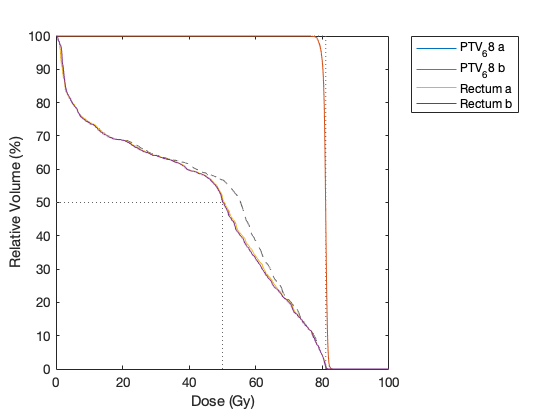

In [233]:
% Compare dose-volume histograms
plotDVHcompare(f1,x1a,x1b)

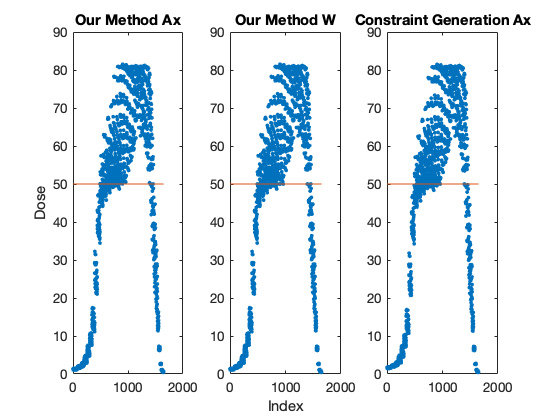

In [234]:
% Comparing voxels
compareVoxels(f1,2,1,x1a,x1b,50)

% Methods seem to target same voxels. Could be due in part to using same initialization.

## Example 4.1(b)

* Our Method: 50.45 seconds
* Constraint Generation: 7.42 seconds

### PTV
* Uniform dose of 81 Gy to prostate

Method | Min | Mean | Median | D95 | Max | Stdev | Obj
-|-|-|-|-|-|-|-
Initialization | 76.00 | 80.88 | 80.96 | 79.65 | 83.39 | 0.65 | 54.44
Our Method | 72.59 | 80.84 | 80.95 | 79.18 | 84.67 | 0.93 | 77.19
Constraint Generation | 72.32 | 80.84 | 80.95 | 79.12 | 85.10 | 0.97 | 80.64

### OAR
* No more than 30% of rectum volume may exceed 30 Gy

Method | % OAR > 30 | Area
-|-|-
Initialization | 64.14 | 4333.84
Our Method | 33.37 | 2786.89
Constraint Generation | 29.98 | 2624.35

In [272]:
% Problem parameters
prostate.terms = {pt1};
rectum.terms = {rt2};
pars.structs = {prostate,rectum};

% Create problem instance
f2 = FluenceMapOpt(pars);
printStats(f2,f2.xInit)

Structure: PTV_68
* unif | 76.00 | 80.88 | 80.96 | 79.65 | 83.39 | 0.65 | 54.44
Structure: Rectum
* udvc | 64.14 | 4333.84


In [273]:
% Solve with our method
tic;
f2.calcDose();
t = toc;
x2a = f2.x;
fprintf('Time: %.2f\n',t)
printStats(f2,x2a)

Time: 50.45
Structure: PTV_68
* unif | 72.59 | 80.84 | 80.95 | 79.18 | 84.67 | 0.93 | 77.19
Structure: Rectum
* udvc | 33.37 | 2786.89


In [275]:
% Solve with constraint generation method
tic;
f2.constGen(); 
t = toc;
x2b = f2.x;
fprintf('Time: %.2f\n',t)
printStats(f2,x2b)


Minimum found that satisfies the constraints.

Optimization completed because the objective function is non-decreasing in 
feasible directions, to within the value of the optimality tolerance,
and constraints are satisfied to within the value of the constraint tolerance.

Time: 7.42
Structure: PTV_68
* unif | 72.32 | 80.84 | 80.95 | 79.12 | 85.10 | 0.97 | 80.64
Structure: Rectum
* udvc | 29.98 | 2624.35


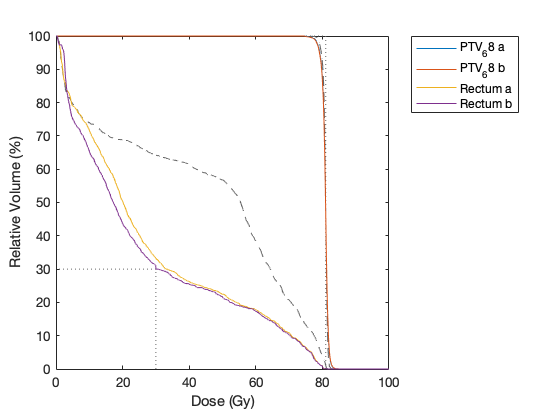

In [238]:
% Compare dose-volume histograms
plotDVHcompare(f2,x2a,x2b)

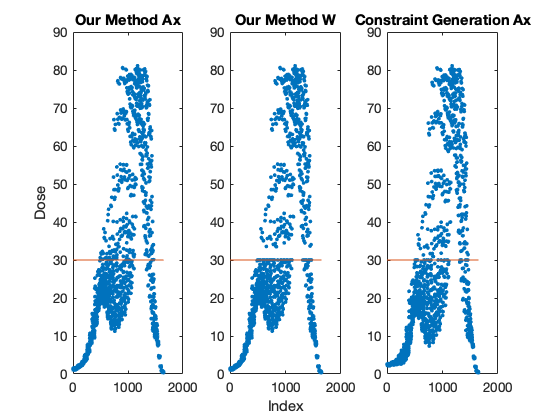

In [239]:
% Comparing voxels
compareVoxels(f2,2,1,x2a,x2b,30)

## Example 4.1(c)

* Our Method: 46.18 seconds
* Constraint Generation: 10.83 seconds

### PTV
* Uniform dose of 81 Gy to prostate

Method | Min | Mean | Median | D95 | Max | Stdev | Obj
-|-|-|-|-|-|-|-
Initialization | 76.00 | 80.88 | 80.96 | 79.65 | 83.39 | 0.65 | 54.44
Our Method | 42.31 | 80.39 | 80.84 | 74.83 | 92.31 | 4.28 | 355.36
Constraint Generation | 16.73 | 78.53 | 80.37 | 57.29 | 97.67 | 9.84 | 834.90

### OAR
* No more than 10% of rectum volume may exceed 10 Gy

Method | % OAR > 10 | Area
-|-|-
Initialization | 73.97 | 4333.84
Our Method | 23.91 | 937.44
Constraint Generation | 8.19 | 472.06

In [276]:
% Problem parameters
prostate.terms = {pt1};
rectum.terms = {rt3};
pars.structs = {prostate,rectum};

% Create problem instance
f3 = FluenceMapOpt(pars);
printStats(f3,f3.xInit)

Structure: PTV_68
* unif | 76.00 | 80.88 | 80.96 | 79.65 | 83.39 | 0.65 | 54.44
Structure: Rectum
* udvc | 73.97 | 4333.84


In [277]:
% Solve with our method
tic;
f3.calcDose();
t = toc;
x3a = f3.x;
fprintf('Time: %.2f\n',t)
printStats(f3,x3a)

Time: 46.18
Structure: PTV_68
* unif | 42.31 | 80.39 | 80.84 | 74.83 | 92.31 | 4.28 | 355.36
Structure: Rectum
* udvc | 23.91 | 937.44


In [278]:
% Solve with constraint generation method
tic;
f3.constGen();
t = toc;
x3b = f3.x;
fprintf('Time: %.2f\n',t)
printStats(f3,x3b)


Minimum found that satisfies the constraints.

Optimization completed because the objective function is non-decreasing in 
feasible directions, to within the value of the optimality tolerance,
and constraints are satisfied to within the value of the constraint tolerance.

Time: 10.83
Structure: PTV_68
* unif | 16.73 | 78.53 | 80.37 | 57.29 | 97.67 | 9.84 | 834.90
Structure: Rectum
* udvc | 8.19 | 472.06


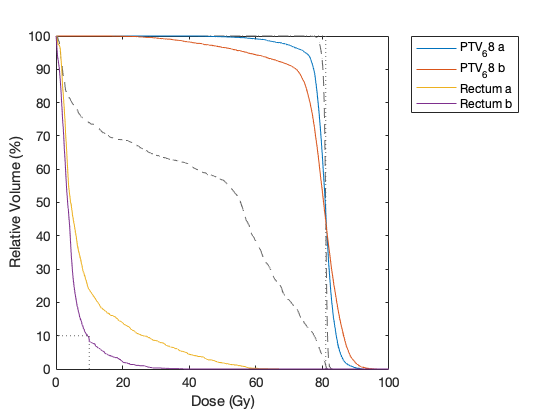

In [127]:
% Compare dose-volume histograms
plotDVHcompare(f3,x3a,x3b)

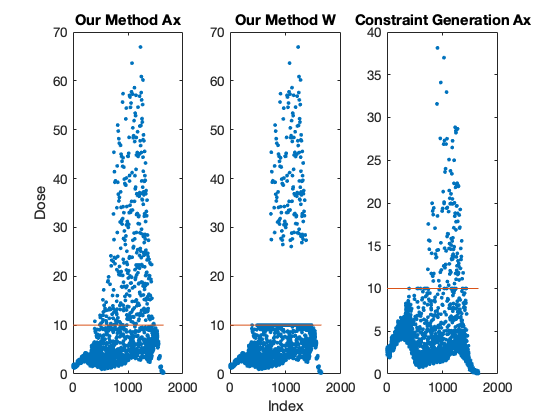

In [99]:
% Comparing voxels
compareVoxels(f3,2,1,x3a,x3b,10)

% Ooh, now we have something a little different!

## Example 4.2

* Our Method: 96.35 seconds
* Constraint Generation: 31.15 seconds

### PTV
* Uniform dose of 81 Gy to prostate

Method | Min | Mean | Median | D95 | Max | Stdev | Obj
-|-|-|-|-|-|-|-
Initialization | 76.00 | 80.88 | 80.96 | 79.65 | 83.39 | 0.65 | 54.44
Our Method | 75.25 | 80.82 | 80.94 | 79.04 | 83.46 | 0.88 | 73.98
Constraint Generation | 73.09 | 80.77 | 80.94 | 78.74 | 83.48 | 1.07 | 90.02

### OAR
* No more than 60% of rectum volume may exceed 20 Gy
* No more than 50% of the rectum volume may exceed 50 Gy
* No more than 20% of the rectum volume may exceed 60 Gy
* No more than 0% of the rectum volume may exceed 75 Gy

Method | % OAR > 20 | % OAR > 50 | % OAR > 60 | % OAR > 75 | Area
-|-|-|-|-|-
Initialization | 68.81 | 56.80 | 38.47 | 13.41 | 4333.84
Our Method | 61.35 | 46.60 | 21.84 | 3.88 | 3612.14
Constraint Generation | 60.01 | 39.08 | 19.36 | 0.00 | 3429.25

In [279]:
% Problem parameters
prostate.terms = {pt1};
rectum.terms = {rt1,rt4,rt5,rt6};
pars.structs = {prostate,rectum};

% Create problem instance
f4 = FluenceMapOpt(pars);
printStats(f4,f4.xInit)

Structure: PTV_68
* unif | 76.00 | 80.88 | 80.96 | 79.65 | 83.39 | 0.65 | 54.44
Structure: Rectum
* udvc | 56.80 | 4333.84
* udvc | 13.41 | 4333.84
* udvc | 38.47 | 4333.84
* udvc | 68.81 | 4333.84


In [280]:
% Solve with our method
tic;
f4.calcDose();
t = toc;
x4a = f4.x;
fprintf('Time: %.2f\n',t)
printStats(f4,x4a)

Time: 96.35
Structure: PTV_68
* unif | 75.25 | 80.82 | 80.94 | 79.04 | 83.46 | 0.88 | 73.98
Structure: Rectum
* udvc | 46.60 | 3612.14
* udvc | 3.88 | 3612.14
* udvc | 21.84 | 3612.14
* udvc | 61.35 | 3612.14


In [281]:
% Solve with constraint generation method
tic;
f4.constGen();
t = toc;
x4b = f4.x;
fprintf('Time: %.2f\n',t)
printStats(f4,x4b)


Minimum found that satisfies the constraints.

Optimization completed because the objective function is non-decreasing in 
feasible directions, to within the value of the optimality tolerance,
and constraints are satisfied to within the value of the constraint tolerance.

Time: 31.15
Structure: PTV_68
* unif | 73.09 | 80.77 | 80.94 | 78.74 | 83.48 | 1.07 | 90.02
Structure: Rectum
* udvc | 39.08 | 3429.25
* udvc | 0.00 | 3429.25
* udvc | 19.36 | 3429.25
* udvc | 60.01 | 3429.25


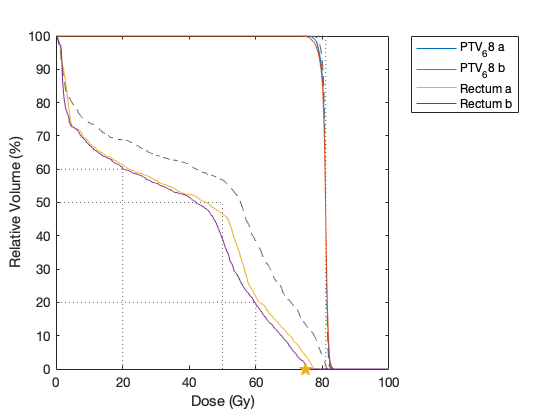

In [161]:
% Compare dose-volume histograms
plotDVHcompare(f4,x4a,x4b)

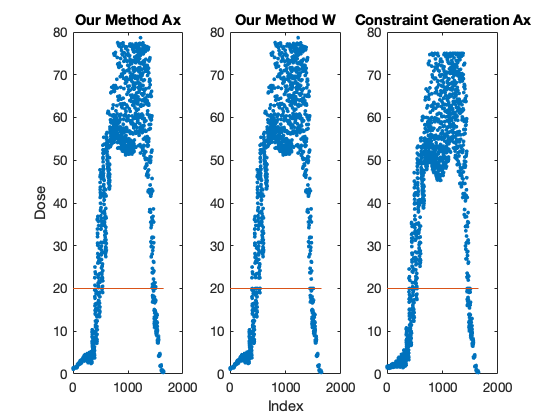

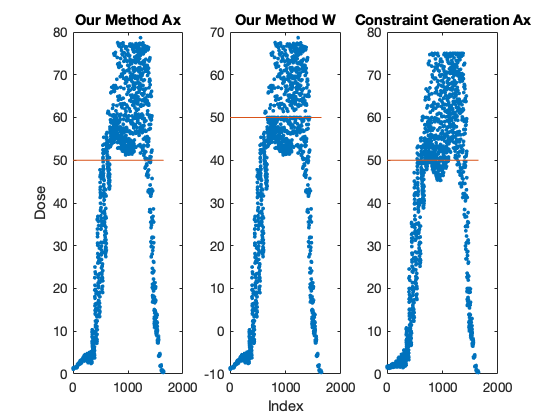

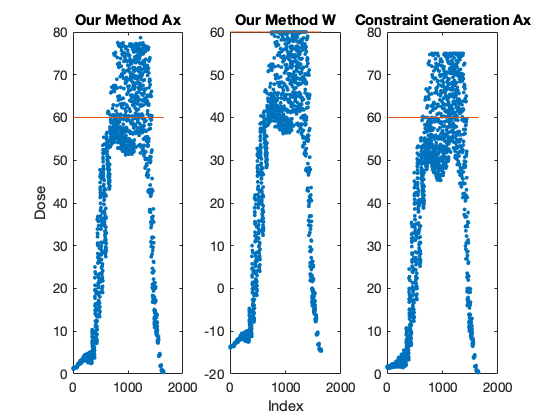

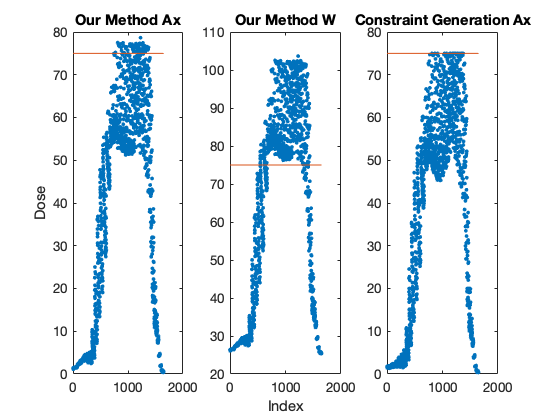

In [162]:
% Comparing voxels
compareVoxels(f4,2,1,x4a,x4b,75)
figure, compareVoxels(f4,2,2,x4a,x4b,60)
figure, compareVoxels(f4,2,3,x4a,x4b,50)
figure, compareVoxels(f4,2,4,x4a,x4b,20)

## Example 4.3

* Our Method: 126.58 seconds
* Constraint Generation: 44.02 seconds

### PTV
* Uniform dose of 81 Gy to prostate

Method | Min | Mean | Median | D95 | Max | Stdev | Obj
-|-|-|-|-|-|-|-
Initialization | 67.55 | 80.55 | 80.93 | 77.14 | 85.86 | 1.88 | 159.01
Our Method | 66.96 | 80.53 | 80.94 | 76.73 | 85.97 | 1.94 | 164.61
Constraint Generation | 66.53 | 80.52 | 80.93 | 76.64 | 86.06 | 1.97 | 166.68

* Uniform dose of 60 Gy to lymph nodes

Method | Min | Mean | Median | D95 | Max | Stdev | Obj
-|-|-|-|-|-|-|-
Initialization | 52.86 | 60.26 | 59.97 | 58.57 | 75.17 | 1.87 | 172.34
Our Method | 51.00 | 60.19 | 59.98 | 57.79 | 75.16 | 2.09 | 191.28
Constraint Generation | 48.73 | 60.15 | 59.97 | 57.46 | 75.35 | 2.19 | 200.20

### OAR
* No more than 50% of the rectum volume may exceed 50 Gy
* No more than 30% of the bladder volume may exceed 30 Gy

Method | % R > 50 | R Area | % B > 30 | B Area
-|-|-|-|-
Initialization | 82.04 | 5671.84 | 92.21 | 4780.08
Our Method | 57.04 | 5161.10 | 35.70 | 3294.49
Constraint Generation | 50.00 | 5097.80 | 29.99 | 3007.40

In [282]:
% Problem parameters
prostate.terms = {pt1};
nodes.terms = {nt1};
rectum.terms = {rt1};
bladder.terms = {bt1};
pars.structs = {prostate,rectum,bladder,nodes};

% Create problem instance
f5 = FluenceMapOpt(pars);
printStats(f5,f5.xInit)

Structure: PTV_68
* unif | 67.55 | 80.55 | 80.93 | 77.14 | 85.86 | 1.88 | 159.01
Structure: Rectum
* udvc | 82.04 | 5671.84
Structure: Bladder
* udvc | 92.21 | 4780.08
Structure: PTV_56
* unif | 52.86 | 60.26 | 59.97 | 58.57 | 75.17 | 1.87 | 172.34


In [283]:
% Solve with our method
tic;
f5.calcDose();
t = toc;
x5a = f5.x;
fprintf('Time: %.2f\n',t)
printStats(f5,x5a)

Time: 126.58
Structure: PTV_68
* unif | 66.96 | 80.53 | 80.94 | 76.73 | 85.97 | 1.94 | 164.61
Structure: Rectum
* udvc | 57.04 | 5161.10
Structure: Bladder
* udvc | 35.70 | 3294.49
Structure: PTV_56
* unif | 51.00 | 60.19 | 59.98 | 57.79 | 75.16 | 2.09 | 191.28


In [284]:
% Solve with constraint generation method
tic;
f5.constGen(); 
t = toc;
x5b = f5.x;
fprintf('Time: %.2f\n',t)
printStats(f5,x5b)


Minimum found that satisfies the constraints.

Optimization completed because the objective function is non-decreasing in 
feasible directions, to within the value of the optimality tolerance,
and constraints are satisfied to within the value of the constraint tolerance.

Time: 44.02
Structure: PTV_68
* unif | 66.53 | 80.52 | 80.93 | 76.64 | 86.06 | 1.97 | 166.68
Structure: Rectum
* udvc | 50.00 | 5097.80
Structure: Bladder
* udvc | 29.99 | 3007.40
Structure: PTV_56
* unif | 48.73 | 60.15 | 59.97 | 57.46 | 75.35 | 2.19 | 200.20


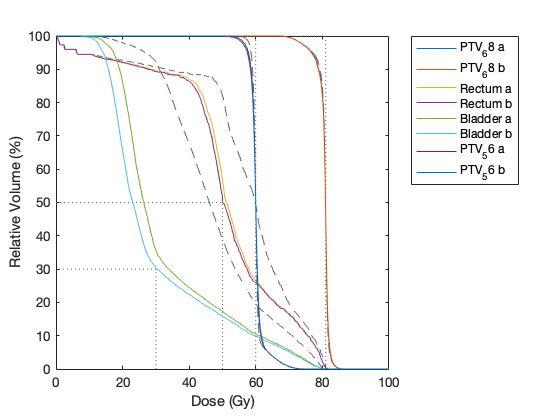

In [166]:
% Compare dose-volume histograms
plotDVHcompare(f5,x5a,x5b)

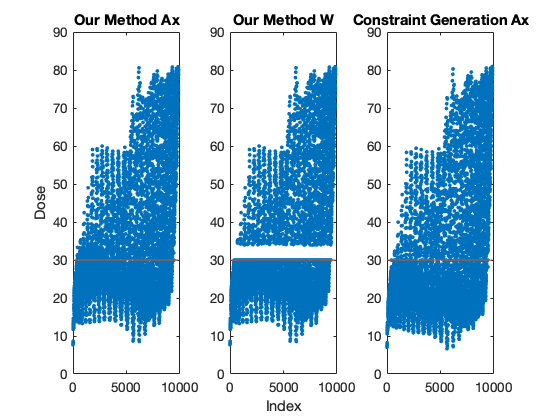

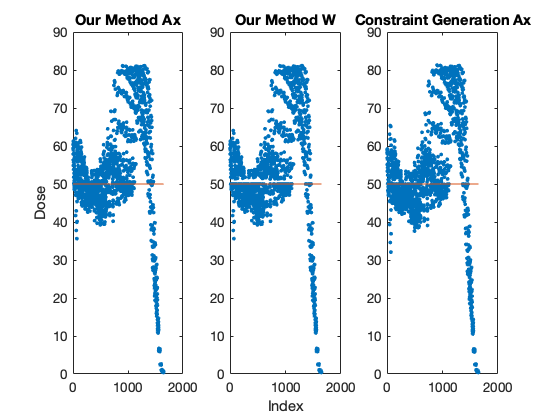

In [111]:
% Comparing voxels
compareVoxels(f5,2,1,x5a,x5b,50)
figure, compareVoxels(f5,3,1,x5a,x5b,30)

## Dose-volume Constraints on PTVs
(Haven't taken out uniform constraints from PTVs yet)
Might need better init with slightly higher uniform dose values for PTVs

* Our Method: 297.72 seconds
* Constraint Generation: 2590.22 seconds (couldn't find feasible solution)

### PTV
* Uniform dose of 81 Gy to prostate
* No more than 5% of the prostate volume may receive less than 81 Gy
* No more than 0% of the prostate volume may exceed 112% of 81 Gy

Method | Min | Mean | Median | D95 | Max | Stdev | Obj | % < 81 | % > max 
-|-|-|-|-|-|-|-|-|-
Initialization | 67.55 | 80.55 | 80.93 | 77.14 | 85.86 | 1.88 | 159.01 | 55.21 | 0.00
Our Method | 67.22 | 80.75 | 81.09 | 77.11 | 86.48 | 1.94 | 160.59 | 44.09 | 0.00
Constraint Generation | 63.09 | 82.62 | 82.63 | 75.79 | 91.65 | 4.51 | 394.46 | 35.89 | 1.31

* Uniform dose of 60 Gy to lymph nodes
* No more than 5% of the lymph nodes volume may receive less than 60 Gy
* No more than 0% of the lymph nodes volume may exceed 112% of 60 Gy

Method | Min | Mean | Median | D95 | Max | Stdev | Obj | % < 60 | % > max
-|-|-|-|-|-|-|-|-|-
Initialization | 52.86 | 60.26 | 59.97 | 58.57 | 75.17 | 1.87 | 172.34 | 52.29 | 2.16
Our Method | 52.86 | 60.26 | 59.97 | 58.57 | 75.17 | 1.87 | 172.34 | 43.22 | 2.26
Constraint Generation | 43.35 | 61.65 | 61.65 | 56.30 | 68.86 | 3.39 | 344.03 | 33.22 | 4.27

### OAR
* No more than 50% of the rectum volume may exceed 50 Gy
* No more than 30% of the bladder volume may exceed 30 Gy

Method | % R > 50 | R Area | % B > 30 | B Area
-|-|-|-|-
Initialization | 82.04 | 5671.84 | 92.21 | 4780.08
Our Method | 57.28 | 5186.43 | 36.14 | 3302.18
Constraint Generation | 46.54 | 5264.82 | 30.22 | 2982.25

In [287]:
% Problem parameters
prostate.terms = {pt1,pt2,pt3};
nodes.terms = {nt1,nt2,nt3};
rectum.terms = {rt1};
bladder.terms = {bt1};
pars.structs = {prostate,rectum,bladder,nodes};

% % Create problem instance
f6 = FluenceMapOpt(pars);
printStats(f6,f6.xInit)

Structure: PTV_68
* unif | 67.55 | 80.55 | 80.93 | 77.14 | 85.86 | 1.88 | 159.01
* ldvc | 55.21
* udvc | 0.00 | 8055.26
Structure: Rectum
* udvc | 82.04 | 5671.84
Structure: Bladder
* udvc | 92.21 | 4780.08
Structure: PTV_56
* unif | 52.86 | 60.26 | 59.97 | 58.57 | 75.17 | 1.87 | 172.34
* ldvc | 52.29
* udvc | 2.16 | 6025.99


In [288]:
% Solve with our method
tic;
f6.calcDose();
t = toc;
x6a = f6.x;
fprintf('Time: %.2f\n',t)
printStats(f6,x6a)

Time: 297.72
Structure: PTV_68
* unif | 67.22 | 80.75 | 81.09 | 77.11 | 86.48 | 1.94 | 160.59
* ldvc | 44.09
* udvc | 0.00 | 8074.50
Structure: Rectum
* udvc | 57.28 | 5186.43
Structure: Bladder
* udvc | 36.14 | 3302.18
Structure: PTV_56
* unif | 50.56 | 60.37 | 60.13 | 58.10 | 75.34 | 2.06 | 190.98
* ldvc | 43.22
* udvc | 2.26 | 6037.20


In [302]:
% Solve with constraint generation method
tic;
f6.constGen();
t = toc;
x6b = f6.x;
fprintf('Time: %.2f\n',t)
printStats(f6,x6b)


No feasible solution found.

lsqlin stopped because it was unable to find a point that satisfies
the constraints within the value of the constraint tolerance.

Time: 2590.22
Structure: PTV_68
* unif | 63.09 | 82.62 | 82.63 | 75.79 | 91.65 | 4.51 | 394.46
* ldvc | 35.89
* udvc | 1.31 | 8262.08
Structure: Rectum
* udvc | 46.54 | 5264.82
Structure: Bladder
* udvc | 30.22 | 2982.25
Structure: PTV_56
* unif | 43.35 | 61.65 | 61.65 | 56.30 | 68.86 | 3.39 | 344.03
* ldvc | 33.22
* udvc | 4.27 | 6164.59


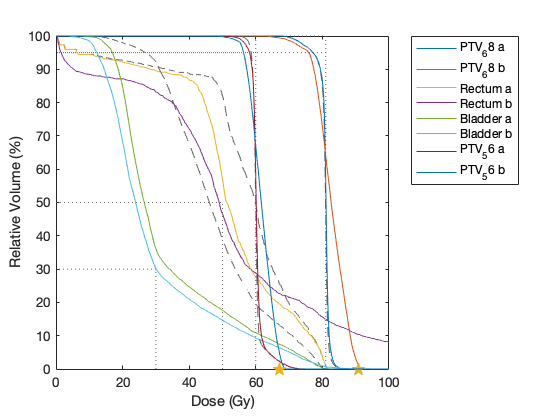

In [303]:
% Compare dose-volume histograms
plotDVHcompare(f6,x6a,x6b)

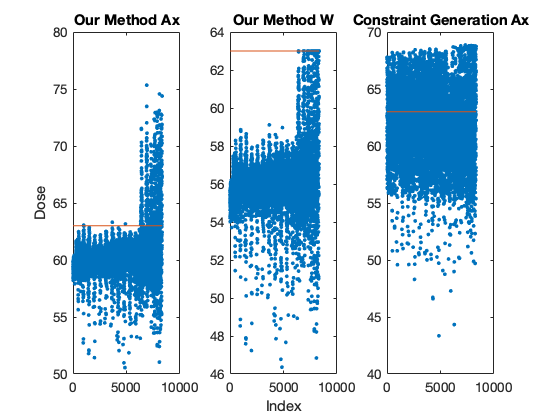

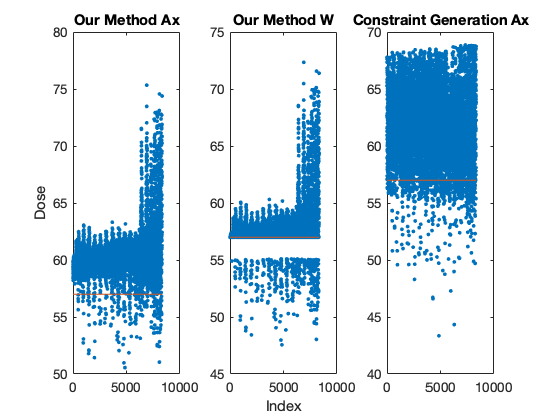

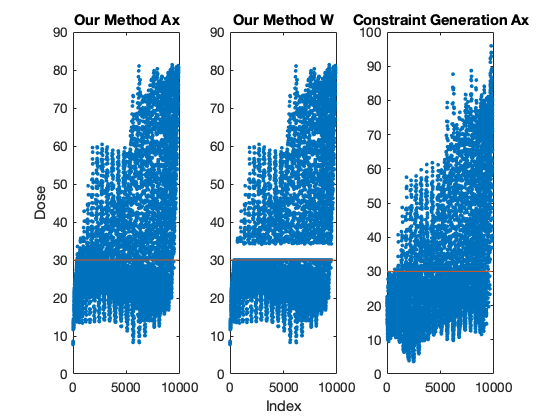

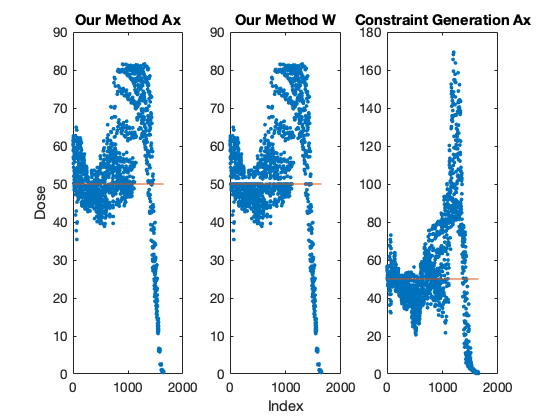

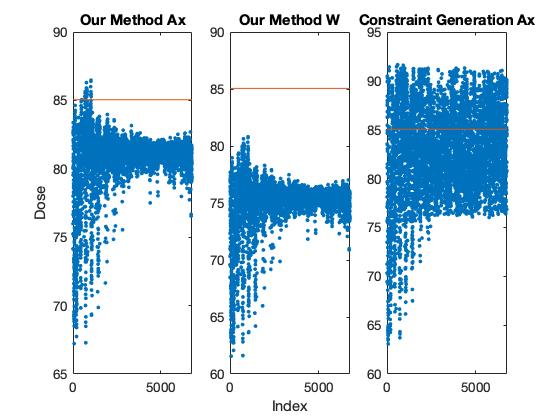

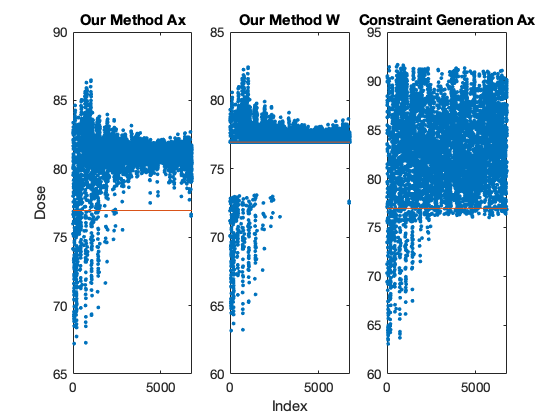

In [304]:
% Comparing voxels
compareVoxels(f6,1,2,x6a,x6b,0.95*81)
figure, compareVoxels(f6,1,3,x6a,x6b,1.05*81)
figure, compareVoxels(f6,2,1,x6a,x6b,50)
figure, compareVoxels(f6,3,1,x6a,x6b,30)
figure, compareVoxels(f6,4,2,x6a,x6b,0.95*60)
figure, compareVoxels(f6,4,3,x6a,x6b,1.05*60)